# Introduction to Neural Nets

This Colab builds a deep neural network to perform more sophisticated linear regression than the earlier Colabs.

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=intro_to_nn_tf2-colab&hl=en

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Create a simple deep neural network.
  * Tune the hyperparameters for a simple deep neural network.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import math
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


## Load the dataset

Like most of the previous Colab exercises, this exercise uses the California Housing Dataset.  The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set
   

In [2]:
# Load the dataset
orign_train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Shuffle the examples
orign_train_df = orign_train_df.reindex(np.random.permutation(orign_train_df.index))

## Normalize values

When building a model with multiple features, the values of each feature should cover roughly the same range.  The following code cell normalizes datasets by converting each raw value to its Z-score. (For more information about Z-scores, see the Classification exercise.)

In [3]:
# Calculate the Z-scores of each column in the training set:
train_df_mean = orign_train_df.mean()
train_df_std = orign_train_df.std()
train_df_norm = (orign_train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


In [4]:
# resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# feature_columns = []

# # Create a bucket feature column for latitude.
# latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
# latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
#                                      int(max(train_df_norm['latitude'])), 
#                                      resolution_in_Zs))
# latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# # Create a bucket feature column for longitude.
# longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
# longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
#                                       int(max(train_df_norm['longitude'])), 
#                                       resolution_in_Zs))

# # Represent median_income as a floating-point value.
# median_income = tf.feature_column.numeric_column("median_income")
# feature_columns.append(median_income)

# # Represent population as a floating-point value.
# population = tf.feature_column.numeric_column("population")
# feature_columns.append(population)

# # Convert the list of feature columns into a layer that will later be fed into
# # the model. 
# # my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
# feature_columns

# Construct features
def coord_bins(coord):
    # returns the `bins` parameter in pd.cut
    return np.linspace(np.min(coord), np.max(coord), 10) # 在指定的時間間隔內返回均勻分布的數字


def coord_to_loc(longitude, latitude):
    longitude_bins, latitude_bins = coord_bins(longitude), coord_bins(latitude)
    longitude_binned = np.digitize(longitude, bins=longitude_bins) # 獲取每個值所屬數組的bin的索引
    latitude_binned = np.digitize(latitude, bins=latitude_bins)

    longitude_binned_onehot, latitude_binned_onehot = (
        pd.get_dummies(longitude_binned),
        pd.get_dummies(latitude_binned),
    )
    
    # numpy.einsum在初學的時候也許不是必要的函數，但對於時間複雜度高的計算，此方程式可以提高運算速度，主要用於計算向量及矩陣，
    # 總共有兩個部分組成，一是計算規則，二是要計算的陣列或矩陣
    
    return np.einsum(
        "...i,...j", longitude_binned_onehot, latitude_binned_onehot
    ).reshape(longitude.shape[0], -1)

In [5]:
loc_train = coord_to_loc(train_df_norm["longitude"], train_df_norm["latitude"])
loc_test = coord_to_loc(test_df_norm["longitude"], test_df_norm["latitude"])

x_train = np.hstack(
    (train_df_norm[["median_income", "population"]].to_numpy(), loc_train)
)
x_test = np.hstack((test_df_norm[["median_income", "population"]].to_numpy(), loc_test))

print(loc_train.shape)
print(loc_test.shape)

print(x_train.shape)
print(x_test.shape)

(17000, 100)
(3000, 100)
(17000, 102)
(3000, 102)


In [6]:
class HousingDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y.to_numpy().reshape(-1, 1), dtype=torch.float)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(self.y)


dat = HousingDataset(x_train, train_df_norm["median_house_value"])
dat_test = HousingDataset(x_test, test_df_norm["median_house_value"])

In [7]:
num_features = dat.x.shape[1]
print(f"num_features: {num_features}")

num_features: 102


## Build a linear regression model as a baseline

Before creating a deep neural net, find a [baseline](https://developers.google.com/machine-learning/glossary/#baseline) loss by running a simple linear regression model that uses the feature layer you just created. 


In [8]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(num_features, 1)                    
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=102, out_features=1, bias=True)
  )
)

In [9]:
from sklearn.model_selection import train_test_split

# The following variables are the hyperparameters.
learning_rate = 0.01
n_epochs = 15
batch_size = 1000
label_name = "median_house_value"


train_ds, valid_ds = train_test_split(dat, test_size=0.2)

train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=True)

valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

test_loader=DataLoader(dat_test,batch_size=batch_size,shuffle=False)

In [10]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")


[ Epoch | 001/015 ]           train_loss = 0.57865 mean_squared_error = 0.57865



[ Epoch | 002/015 ]           train_loss = 0.39834 mean_squared_error = 0.39834



[ Epoch | 003/015 ]           train_loss = 0.38171 mean_squared_error = 0.38171



[ Epoch | 004/015 ]           train_loss = 0.38176 mean_squared_error = 0.38176



[ Epoch | 005/015 ]           train_loss = 0.38112 mean_squared_error = 0.38112



[ Epoch | 006/015 ]           train_loss = 0.38087 mean_squared_error = 0.38087



[ Epoch | 007/015 ]           train_loss = 0.38104 mean_squared_error = 0.38104



[ Epoch | 008/015 ]           train_loss = 0.38117 mean_squared_error = 0.38117



[ Epoch | 009/015 ]           train_loss = 0.38130 mean_squared_error = 0.38130



[ Epoch | 010/015 ]           train_loss = 0.38065 mean_squared_error = 0.38065



[ Epoch | 011/015 ]           train_loss = 0.38075 mean_squared_error = 0.38075



[ Epoch | 012/015 ]           train_loss = 0.38086 mean_squared_error = 0.38086



[ Epoch | 013/015 ]           train_loss = 0.38019 mean_squared_error = 0.38019



[ Epoch | 014/015 ]           train_loss = 0.38078 mean_squared_error = 0.38078



[ Epoch | 015/015 ]           train_loss = 0.38191 mean_squared_error = 0.38191
Defined the build_model and train_model functions.


In [11]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} mean_squared_error = {test_loss:.5f}")    


test_loss = 0.40784 mean_squared_error = 0.40784


## Define a deep neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

In [12]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(num_features, 20) ,                   
                    nn.Linear(20, 12),
                    nn.Linear(12, 1),
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=102, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=12, bias=True)
    (2): Linear(in_features=12, out_features=1, bias=True)
  )
)

## Define a training function

The `train_model` function trains the model from the input features and labels. The [tf.keras.Model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) method performs the actual training. The `x` parameter of the `fit` method is very flexible, enabling you to pass feature data in a variety of ways. The following implementation passes a Python dictionary in which:

* The *keys* are the names of each feature (for example, `longitude`, `latitude`, and so on).
* The *value* of each key is a NumPy array containing the values of that feature. 

**Note:** Although you are passing *every* feature to `model.fit`, most of those values will be ignored. Only the features accessed by `my_feature_layer` will actually be used to train the model.

In [13]:
# The following variables are the hyperparameters.
learning_rate = 0.01
n_epochs = 20
batch_size = 1000


[ Epoch | 001/020 ]           train_loss = 0.56859 mean_squared_error = 0.56859



[ Epoch | 002/020 ]           train_loss = 0.38325 mean_squared_error = 0.38325



[ Epoch | 003/020 ]           train_loss = 0.38320 mean_squared_error = 0.38320



[ Epoch | 004/020 ]           train_loss = 0.38812 mean_squared_error = 0.38812



[ Epoch | 005/020 ]           train_loss = 0.38415 mean_squared_error = 0.38415



[ Epoch | 006/020 ]           train_loss = 0.38632 mean_squared_error = 0.38632



[ Epoch | 007/020 ]           train_loss = 0.38157 mean_squared_error = 0.38157



[ Epoch | 008/020 ]           train_loss = 0.38317 mean_squared_error = 0.38317



[ Epoch | 009/020 ]           train_loss = 0.38333 mean_squared_error = 0.38333



[ Epoch | 010/020 ]           train_loss = 0.38933 mean_squared_error = 0.38933



[ Epoch | 011/020 ]           train_loss = 0.38400 mean_squared_error = 0.38400



[ Epoch | 012/020 ]           train_loss = 0.38610 mean_squared_error = 0.38610



[ Epoch | 013/020 ]           train_loss = 0.38518 mean_squared_error = 0.38518



[ Epoch | 014/020 ]           train_loss = 0.38473 mean_squared_error = 0.38473



[ Epoch | 015/020 ]           train_loss = 0.38509 mean_squared_error = 0.38509



[ Epoch | 016/020 ]           train_loss = 0.38673 mean_squared_error = 0.38673



[ Epoch | 017/020 ]           train_loss = 0.38594 mean_squared_error = 0.38594



[ Epoch | 018/020 ]           train_loss = 0.38536 mean_squared_error = 0.38536



[ Epoch | 019/020 ]           train_loss = 0.38213 mean_squared_error = 0.38213



[ Epoch | 020/020 ]           train_loss = 0.38391 mean_squared_error = 0.38391
Defined the build_model and train_model functions.


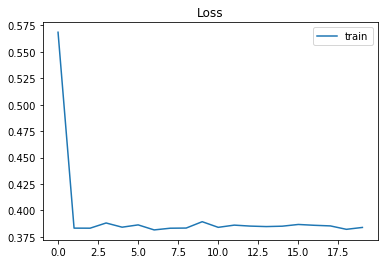

In [14]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")



import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

In [15]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} mean_squared_error = {test_loss:.5f}")    


test_loss = 0.40823 mean_squared_error = 0.40823


## Task 3: Regularize the deep neural network (if you have enough time)

Notice that the model's loss against the test set is *much higher* than the loss against the training set.  In other words, the deep neural network is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) to the data in the training set.  To reduce overfitting, regularize the model.  The course has suggested several different ways to regularize a model, including:

  * [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization)
  * [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization)
  * [Dropout regularization](https://developers.google.com/machine-learning/glossary/#dropout_regularization)

Your task is to experiment with one or more regularization mechanisms to bring the test loss closer to the training loss (while still keeping test loss relatively low).  

**Note:** When you add a regularization function to a model, you might need to tweak other hyperparameters. 

### Implementing L1 or L2 regularization

To use L1 or L2 regularization on a hidden layer, specify the `kernel_regularizer` argument to [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Assign one of the following methods to this argument:

* `tf.keras.regularizers.l1` for L1 regularization
* `tf.keras.regularizers.l2` for L2 regularization

Each of the preceding methods takes an `l` parameter, which adjusts the [regularization rate](https://developers.google.com/machine-learning/glossary/#regularization_rate). Assign a decimal value between 0 and 1.0 to `l`; the higher the decimal, the greater the regularization. For example, the following applies L2 regularization at a strength of 0.01. 

```
model.add(tf.keras.layers.Dense(units=20, 
                                activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                name='Hidden1'))
```

## Regularization

Note that the model's loss against the test set is much higher than the loss against the training set. This indicates the model is overfitting to the data, and we need regularization to reduce the overfitting. Try L1, L2 and dropout regularizations.

- For L1 regularization, add `nn.L1Loss` to the list of loss functions: `loss = nn.MSELoss()(y_hat, y) + lambda * nn.L1Loss()(y_hat, y)`.
- For L2 regularization, use the `weight_decay` parameter in the optimizer, e.g. `torch.optim.SGD`.
- See below for an example of adding dropout layers.


In [16]:
# https://pyquestions.com/adding-l1-l2-regularization-in-pytorch
# https://github.com/szymonmaszke/torchlayers/blob/master/torchlayers/regularization.py

class L1(torch.nn.Module):
    def __init__(self, module, weight_decay):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay

        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    # Not dependent on backprop incoming values, placeholder
    def _weight_decay_hook(self, *_):
        for param in self.module.parameters():
            # If there is no gradient or it was zeroed out
            # Zeroed out using optimizer.zero_grad() usually
            # Turn on if needed with grad accumulation/more safer way
            # if param.grad is None or torch.all(param.grad == 0.0):

            # Apply regularization on it
            param.grad = self.regularize(param)

    def regularize(self, parameter):
        # L1 regularization formula
        return self.weight_decay * torch.sign(parameter.data)

    def forward(self, *args, **kwargs):
        # Simply forward and args and kwargs to module
        return self.module(*args, **kwargs)
    
class L2(torch.nn.Module):
    def __init__(self, module, weight_decay):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay

        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    # Not dependent on backprop incoming values, placeholder
    def _weight_decay_hook(self, *_):
        for param in self.module.parameters():
            # If there is no gradient or it was zeroed out
            # Zeroed out using optimizer.zero_grad() usually
            # Turn on if needed with grad accumulation/more safer way
            # if param.grad is None or torch.all(param.grad == 0.0):

            # Apply regularization on it
            param.grad = self.regularize(param)

    def regularize(self, parameter):
        # L2 regularization formula
        return self.weight_decay * parameter.data

    def forward(self, *args, **kwargs):
        # Simply forward and args and kwargs to module
        return self.module(*args, **kwargs)    

### Implementing Dropout regularization

You implement dropout regularization as a separate layer in the topography. For example, the following code demonstrates how to add a dropout regularization layer between the first hidden layer and the second hidden layer:

```
model.add(tf.keras.layers.Dense( *define first hidden layer*)
 
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Dense( *define second hidden layer*)
```

The `rate` parameter to [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) specifies the fraction of nodes that the model should drop out during training. 


In [17]:
learning_rate = 0.007
n_epochs = 140
batch_size = 1000

In [18]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    L2(nn.Linear(num_features, 20), weight_decay=0.01) ,   
                    nn.Dropout(0.25),
                    nn.Linear(20, 12),
                    nn.Linear(12, 1),
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): L2(
      (module): Linear(in_features=102, out_features=20, bias=True)
    )
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=20, out_features=12, bias=True)
    (3): Linear(in_features=12, out_features=1, bias=True)
  )
)


[ Epoch | 001/140 ]           train_loss = 0.73580 mean_squared_error = 0.73580



[ Epoch | 002/140 ]           train_loss = 0.43491 mean_squared_error = 0.43491



[ Epoch | 003/140 ]           train_loss = 0.40711 mean_squared_error = 0.40711



[ Epoch | 004/140 ]           train_loss = 0.40142 mean_squared_error = 0.40142



[ Epoch | 005/140 ]           train_loss = 0.39934 mean_squared_error = 0.39934



[ Epoch | 006/140 ]           train_loss = 0.39535 mean_squared_error = 0.39535



[ Epoch | 007/140 ]           train_loss = 0.39776 mean_squared_error = 0.39776



[ Epoch | 008/140 ]           train_loss = 0.39479 mean_squared_error = 0.39479



[ Epoch | 009/140 ]           train_loss = 0.39451 mean_squared_error = 0.39451



[ Epoch | 010/140 ]           train_loss = 0.39179 mean_squared_error = 0.39179



[ Epoch | 011/140 ]           train_loss = 0.39392 mean_squared_error = 0.39392



[ Epoch | 012/140 ]           train_loss = 0.39339 mean_squared_error = 0.39339



[ Epoch | 013/140 ]           train_loss = 0.39297 mean_squared_error = 0.39297



[ Epoch | 014/140 ]           train_loss = 0.39102 mean_squared_error = 0.39102



[ Epoch | 015/140 ]           train_loss = 0.39512 mean_squared_error = 0.39512



[ Epoch | 016/140 ]           train_loss = 0.39109 mean_squared_error = 0.39109



[ Epoch | 017/140 ]           train_loss = 0.39199 mean_squared_error = 0.39199



[ Epoch | 018/140 ]           train_loss = 0.39275 mean_squared_error = 0.39275



[ Epoch | 019/140 ]           train_loss = 0.39304 mean_squared_error = 0.39304



[ Epoch | 020/140 ]           train_loss = 0.39308 mean_squared_error = 0.39308



[ Epoch | 021/140 ]           train_loss = 0.39227 mean_squared_error = 0.39227



[ Epoch | 022/140 ]           train_loss = 0.39483 mean_squared_error = 0.39483



[ Epoch | 023/140 ]           train_loss = 0.39236 mean_squared_error = 0.39236



[ Epoch | 024/140 ]           train_loss = 0.39554 mean_squared_error = 0.39554



[ Epoch | 025/140 ]           train_loss = 0.39169 mean_squared_error = 0.39169



[ Epoch | 026/140 ]           train_loss = 0.39265 mean_squared_error = 0.39265



[ Epoch | 027/140 ]           train_loss = 0.39261 mean_squared_error = 0.39261



[ Epoch | 028/140 ]           train_loss = 0.39196 mean_squared_error = 0.39196



[ Epoch | 029/140 ]           train_loss = 0.39006 mean_squared_error = 0.39006



[ Epoch | 030/140 ]           train_loss = 0.39253 mean_squared_error = 0.39253



[ Epoch | 031/140 ]           train_loss = 0.39130 mean_squared_error = 0.39130



[ Epoch | 032/140 ]           train_loss = 0.39304 mean_squared_error = 0.39304



[ Epoch | 033/140 ]           train_loss = 0.39164 mean_squared_error = 0.39164



[ Epoch | 034/140 ]           train_loss = 0.39270 mean_squared_error = 0.39270



[ Epoch | 035/140 ]           train_loss = 0.39049 mean_squared_error = 0.39049



[ Epoch | 036/140 ]           train_loss = 0.39013 mean_squared_error = 0.39013



[ Epoch | 037/140 ]           train_loss = 0.39091 mean_squared_error = 0.39091



[ Epoch | 038/140 ]           train_loss = 0.39173 mean_squared_error = 0.39173



[ Epoch | 039/140 ]           train_loss = 0.38970 mean_squared_error = 0.38970



[ Epoch | 040/140 ]           train_loss = 0.38978 mean_squared_error = 0.38978



[ Epoch | 041/140 ]           train_loss = 0.39004 mean_squared_error = 0.39004



[ Epoch | 042/140 ]           train_loss = 0.39274 mean_squared_error = 0.39274



[ Epoch | 043/140 ]           train_loss = 0.39024 mean_squared_error = 0.39024



[ Epoch | 044/140 ]           train_loss = 0.39216 mean_squared_error = 0.39216



[ Epoch | 045/140 ]           train_loss = 0.38856 mean_squared_error = 0.38856



[ Epoch | 046/140 ]           train_loss = 0.39137 mean_squared_error = 0.39137



[ Epoch | 047/140 ]           train_loss = 0.39124 mean_squared_error = 0.39124



[ Epoch | 048/140 ]           train_loss = 0.39274 mean_squared_error = 0.39274



[ Epoch | 049/140 ]           train_loss = 0.39208 mean_squared_error = 0.39208



[ Epoch | 050/140 ]           train_loss = 0.38890 mean_squared_error = 0.38890



[ Epoch | 051/140 ]           train_loss = 0.39209 mean_squared_error = 0.39209



[ Epoch | 052/140 ]           train_loss = 0.39295 mean_squared_error = 0.39295



[ Epoch | 053/140 ]           train_loss = 0.39065 mean_squared_error = 0.39065



[ Epoch | 054/140 ]           train_loss = 0.39186 mean_squared_error = 0.39186



[ Epoch | 055/140 ]           train_loss = 0.39166 mean_squared_error = 0.39166



[ Epoch | 056/140 ]           train_loss = 0.39261 mean_squared_error = 0.39261



[ Epoch | 057/140 ]           train_loss = 0.38948 mean_squared_error = 0.38948



[ Epoch | 058/140 ]           train_loss = 0.39023 mean_squared_error = 0.39023



[ Epoch | 059/140 ]           train_loss = 0.39128 mean_squared_error = 0.39128



[ Epoch | 060/140 ]           train_loss = 0.39273 mean_squared_error = 0.39273



[ Epoch | 061/140 ]           train_loss = 0.39134 mean_squared_error = 0.39134



[ Epoch | 062/140 ]           train_loss = 0.38931 mean_squared_error = 0.38931



[ Epoch | 063/140 ]           train_loss = 0.38881 mean_squared_error = 0.38881



[ Epoch | 064/140 ]           train_loss = 0.39120 mean_squared_error = 0.39120



[ Epoch | 065/140 ]           train_loss = 0.39231 mean_squared_error = 0.39231



[ Epoch | 066/140 ]           train_loss = 0.38919 mean_squared_error = 0.38919



[ Epoch | 067/140 ]           train_loss = 0.38969 mean_squared_error = 0.38969



[ Epoch | 068/140 ]           train_loss = 0.39143 mean_squared_error = 0.39143



[ Epoch | 069/140 ]           train_loss = 0.39194 mean_squared_error = 0.39194



[ Epoch | 070/140 ]           train_loss = 0.39196 mean_squared_error = 0.39196



[ Epoch | 071/140 ]           train_loss = 0.39312 mean_squared_error = 0.39312



[ Epoch | 072/140 ]           train_loss = 0.38981 mean_squared_error = 0.38981



[ Epoch | 073/140 ]           train_loss = 0.39260 mean_squared_error = 0.39260



[ Epoch | 074/140 ]           train_loss = 0.39212 mean_squared_error = 0.39212



[ Epoch | 075/140 ]           train_loss = 0.39076 mean_squared_error = 0.39076



[ Epoch | 076/140 ]           train_loss = 0.39241 mean_squared_error = 0.39241



[ Epoch | 077/140 ]           train_loss = 0.39622 mean_squared_error = 0.39622



[ Epoch | 078/140 ]           train_loss = 0.38741 mean_squared_error = 0.38741



[ Epoch | 079/140 ]           train_loss = 0.39183 mean_squared_error = 0.39183



[ Epoch | 080/140 ]           train_loss = 0.39353 mean_squared_error = 0.39353



[ Epoch | 081/140 ]           train_loss = 0.39244 mean_squared_error = 0.39244



[ Epoch | 082/140 ]           train_loss = 0.39270 mean_squared_error = 0.39270



[ Epoch | 083/140 ]           train_loss = 0.39263 mean_squared_error = 0.39263



[ Epoch | 084/140 ]           train_loss = 0.39051 mean_squared_error = 0.39051



[ Epoch | 085/140 ]           train_loss = 0.39028 mean_squared_error = 0.39028



[ Epoch | 086/140 ]           train_loss = 0.38898 mean_squared_error = 0.38898



[ Epoch | 087/140 ]           train_loss = 0.39005 mean_squared_error = 0.39005



[ Epoch | 088/140 ]           train_loss = 0.39159 mean_squared_error = 0.39159



[ Epoch | 089/140 ]           train_loss = 0.39094 mean_squared_error = 0.39094



[ Epoch | 090/140 ]           train_loss = 0.39163 mean_squared_error = 0.39163



[ Epoch | 091/140 ]           train_loss = 0.39255 mean_squared_error = 0.39255



[ Epoch | 092/140 ]           train_loss = 0.39029 mean_squared_error = 0.39029



[ Epoch | 093/140 ]           train_loss = 0.39037 mean_squared_error = 0.39037



[ Epoch | 094/140 ]           train_loss = 0.38925 mean_squared_error = 0.38925



[ Epoch | 095/140 ]           train_loss = 0.39027 mean_squared_error = 0.39027



[ Epoch | 096/140 ]           train_loss = 0.39155 mean_squared_error = 0.39155



[ Epoch | 097/140 ]           train_loss = 0.39037 mean_squared_error = 0.39037



[ Epoch | 098/140 ]           train_loss = 0.39122 mean_squared_error = 0.39122



[ Epoch | 099/140 ]           train_loss = 0.38891 mean_squared_error = 0.38891



[ Epoch | 100/140 ]           train_loss = 0.39005 mean_squared_error = 0.39005



[ Epoch | 101/140 ]           train_loss = 0.39142 mean_squared_error = 0.39142



[ Epoch | 102/140 ]           train_loss = 0.38945 mean_squared_error = 0.38945



[ Epoch | 103/140 ]           train_loss = 0.39230 mean_squared_error = 0.39230



[ Epoch | 104/140 ]           train_loss = 0.39141 mean_squared_error = 0.39141



[ Epoch | 105/140 ]           train_loss = 0.39074 mean_squared_error = 0.39074



[ Epoch | 106/140 ]           train_loss = 0.39264 mean_squared_error = 0.39264



[ Epoch | 107/140 ]           train_loss = 0.39274 mean_squared_error = 0.39274



[ Epoch | 108/140 ]           train_loss = 0.39180 mean_squared_error = 0.39180



[ Epoch | 109/140 ]           train_loss = 0.39319 mean_squared_error = 0.39319



[ Epoch | 110/140 ]           train_loss = 0.39370 mean_squared_error = 0.39370



[ Epoch | 111/140 ]           train_loss = 0.39265 mean_squared_error = 0.39265



[ Epoch | 112/140 ]           train_loss = 0.39049 mean_squared_error = 0.39049



[ Epoch | 113/140 ]           train_loss = 0.39112 mean_squared_error = 0.39112



[ Epoch | 114/140 ]           train_loss = 0.39062 mean_squared_error = 0.39062



[ Epoch | 115/140 ]           train_loss = 0.39289 mean_squared_error = 0.39289



[ Epoch | 116/140 ]           train_loss = 0.39175 mean_squared_error = 0.39175



[ Epoch | 117/140 ]           train_loss = 0.39313 mean_squared_error = 0.39313



[ Epoch | 118/140 ]           train_loss = 0.39327 mean_squared_error = 0.39327



[ Epoch | 119/140 ]           train_loss = 0.39474 mean_squared_error = 0.39474



[ Epoch | 120/140 ]           train_loss = 0.39425 mean_squared_error = 0.39425



[ Epoch | 121/140 ]           train_loss = 0.39126 mean_squared_error = 0.39126



[ Epoch | 122/140 ]           train_loss = 0.39153 mean_squared_error = 0.39153



[ Epoch | 123/140 ]           train_loss = 0.39306 mean_squared_error = 0.39306



[ Epoch | 124/140 ]           train_loss = 0.38974 mean_squared_error = 0.38974



[ Epoch | 125/140 ]           train_loss = 0.39210 mean_squared_error = 0.39210



[ Epoch | 126/140 ]           train_loss = 0.39143 mean_squared_error = 0.39143



[ Epoch | 127/140 ]           train_loss = 0.39200 mean_squared_error = 0.39200



[ Epoch | 128/140 ]           train_loss = 0.38960 mean_squared_error = 0.38960



[ Epoch | 129/140 ]           train_loss = 0.39109 mean_squared_error = 0.39109



[ Epoch | 130/140 ]           train_loss = 0.39019 mean_squared_error = 0.39019



[ Epoch | 131/140 ]           train_loss = 0.39140 mean_squared_error = 0.39140



[ Epoch | 132/140 ]           train_loss = 0.39125 mean_squared_error = 0.39125



[ Epoch | 133/140 ]           train_loss = 0.38951 mean_squared_error = 0.38951



[ Epoch | 134/140 ]           train_loss = 0.39156 mean_squared_error = 0.39156



[ Epoch | 135/140 ]           train_loss = 0.39100 mean_squared_error = 0.39100



[ Epoch | 136/140 ]           train_loss = 0.39076 mean_squared_error = 0.39076



[ Epoch | 137/140 ]           train_loss = 0.39025 mean_squared_error = 0.39025



[ Epoch | 138/140 ]           train_loss = 0.39297 mean_squared_error = 0.39297



[ Epoch | 139/140 ]           train_loss = 0.39115 mean_squared_error = 0.39115



[ Epoch | 140/140 ]           train_loss = 0.39051 mean_squared_error = 0.39051
Defined the build_model and train_model functions.


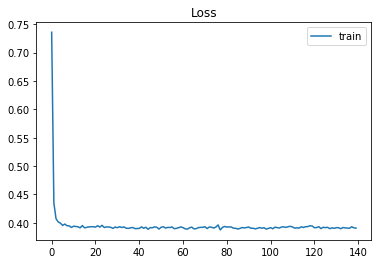

In [19]:
model = Sequential()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0, amsgrad=False)

loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")

import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

In [20]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f}")    


test_loss = 0.40673
